# Simple model analysis


In [1]:
%matplotlib inline
%load_ext autoreload

import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seawater as sw
import xarray as xr
import pop_tools
# %aimport xgcm

# import hvplot.xarray

import dcpy
import pump

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['figure.dpi'] = 140

xr.set_options(keep_attrs=True, display_style="html")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'pop_tools'

In [2]:
import distributed
import ncar_jobqueue

if 'client' in locals():
    client.close(); cluster.close()

cluster = ncar_jobqueue.NCARCluster(
    cores=9, processes=4, memory='109GB',
    walltime='02:00:00', project='NCGD0043')

client = dask.distributed.Client(cluster)

cluster.adapt(minimum=4, maximum=24, wait_count=600)
cluster

## Read data

In [7]:
def estimate_euc_depth_terms(ds):

    ds.load()

    surface = {'depth': -20, 'method': 'nearest'}

    ds['h'] = (ds.eucmax - surface['depth'])
    ds['h'].attrs['long_name'] = '$h$'

    if 'u' in ds:
        ds['us'] = ds.u.sel(**surface)
        ds['ueuc'] = ds.u.interp(depth=ds.eucmax, longitude=ds.longitude, method='linear')
        ds['du'] = ds.us - ds.ueuc
        ds.du.attrs['long_name'] = '$\Delta$u'

    if 'dens' in ds:
        ds['dens_euc'] = ds.dens.interp(depth=ds.eucmax,
                                        longitude=ds.longitude,
                                        method='linear')
        ds['b'] = ds.dens * -9.81/ds.dens_euc
        ds['bs'] = ds.b.sel(**surface)
        ds['beuc'] = -9.81 * xr.ones_like(ds.bs)

        ds['db'] = ds.bs - ds.beuc
        ds.db.attrs['long_name'] = '$\Delta$b'

    if 'db' in ds and 'du' in ds and 'h' in ds:
        with xr.set_options(keep_attrs=False):
            ds['Ri'] = ds.db * np.abs(ds.h) / (ds.du**2)

    return ds

if 'gcm1' in locals():
    import airsea
    print('skipping gcm1, jra, ssh')
    subset = (gcm1.annual.sel(latitude=0, method='nearest')
              .assign_coords(latitude=0)
              .squeeze()
              .sel(depth=slice(0, -250)))
    subset['dens'] = pump.mdjwf.dens(subset.salt, subset.theta, subset.depth)
    subset['eucmax'] = pump.calc.get_euc_max(subset.u)

    subset = estimate_euc_depth_terms(subset)
    subset.attrs['name'] = 'gcm 1m 1996 mean'

    jra = (pump.obs.read_jra()
           .sel(latitude=0, method='nearest')
           .sel(time='1996')
           .load())
    jra['tau'] = jra.Uwind.copy(
        data=airsea.windstress.stress(np.hypot(jra.Uwind, jra.Vwind)))

    mean_jra = jra.mean('time')
    ssh = xr.open_mfdataset(pump.obs.root + 'make_TPOS_MITgcm/1996/SSH*.nc').zos

johnson = (pump.obs.read_johnson()
           .sel(latitude=0))
johnson['eucmax'] = pump.get_euc_max(johnson.u)
johnson = estimate_euc_depth_terms(johnson)
johnson.attrs['name'] = 'Johnson'

# need to fill to the surface
tao_adcp = pump.obs.read_tao_adcp().mean('time').bfill('depth')
tao_adcp['eucmax'] = pump.get_euc_max(tao_adcp.u)

tao_ctd = (pump.obs.read_tao()
           .sel(latitude=0, longitude=tao_adcp.longitude)
           .drop(['u', 'v'])
           .mean('time')
           .compute())
tao_ctd['eucmax'] = tao_adcp.eucmax
tao_ctd['dens'] = pump.mdjwf.dens(np.array(35.0), tao_ctd.temp, tao_ctd.depth)
tao_ctd_raw = tao_ctd.copy(deep=True)
tao_ctd = (tao_ctd
           .sortby('depth')
           .interpolate_na('depth')
           .sortby('depth', ascending=False)
           .bfill('depth'))

tao = xr.merge([estimate_euc_depth_terms(tao_adcp)[['us', 'ueuc', 'du', 'eucmax']],
                estimate_euc_depth_terms(tao_ctd)[['bs', 'beuc', 'db']]])
tao = estimate_euc_depth_terms(tao)
tao.attrs['name'] = 'TAO'

hires = xr.load_dataset('~/pump/glade/small-eq-mean.nc').sel(longitude=slice(-221, None))
hires['eucmax'] = (pump.calc.get_euc_max(hires.u)
                   .rolling(longitude=200, center=True, min_periods=1)
                   .mean())
hires = estimate_euc_depth_terms(hires)

/glade/u/home/dcherian/pump/pump/obs.py:170: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  chunks={"lat": 1, "lon": 1, "depth": 5},
/gpfs/u/home/dcherian/python/xarray/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `co

## Heat flux

In [5]:
qnet = (xr.open_dataset('../glade/obs/tao/qnet_xyt_dy.cdf').rename({
    'QT_210': 'qnet',
    'lat': 'latitude',
    'lon': 'longitude'
})['qnet'])
qnet['longitude'] -= 360
qnet = qnet.where(np.abs(qnet) < 1e5)
qnet

<xarray.DataArray 'qnet' (time: 6469, depth: 1, latitude: 11, longitude: 8)>
array([[[[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
           92.55531]]],


       [[[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,     

## SSH

In [6]:
ssh = (xr.open_mfdataset([pump.obs.root + 'obs/aviso/zos_AVISO_L4_199210-201012.nc'])
      .zos
      .rename({'lat': 'latitude', 'lon': 'longitude'}))
ssh['longitude'] -= 360
ssh = ssh.sel(longitude=slice(-200, -80), latitude=slice(-25, 25)).mean('time').compute()
ssh

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.13 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/gpfs/u/home/dcherian/python/xarray/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


<xarray.DataArray 'zos' (latitude: 50, longitude: 120)>
array([[1.0146531 , 1.0037938 , 0.99376035, ..., 0.63221073, 0.61761034,
        0.6016931 ],
       [1.0273066 , 1.0175812 , 1.0088582 , ..., 0.62273055, 0.6081634 ,
        0.5922261 ],
       [1.046003  , 1.0380611 , 1.0309224 , ..., 0.61169213, 0.597813  ,
        0.5830368 ],
       ...,
       [1.3097773 , 1.3013064 , 1.2935021 , ..., 0.6009446 , 0.6040544 ,
        0.60238636],
       [1.2980543 , 1.2906426 , 1.2837585 , ..., 0.5306964 , 0.53614575,
        0.5542671 ],
       [1.2794156 , 1.2714981 , 1.263941  , ..., 0.43182534, 0.45010972,
        0.49250126]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 -24.5 -23.5 -22.5 -21.5 ... 22.5 23.5 24.5
  * longitude  (longitude) float64 -199.5 -198.5 -197.5 ... -82.5 -81.5 -80.5
Attributes:
    standard_name:     sea_surface_height_above_geoid
    long_name:         Sea Surface Height Above Geoid
    units:             m
    original_name:     maps_of_absolute

Text(0.5, 1.0, 'SSH')

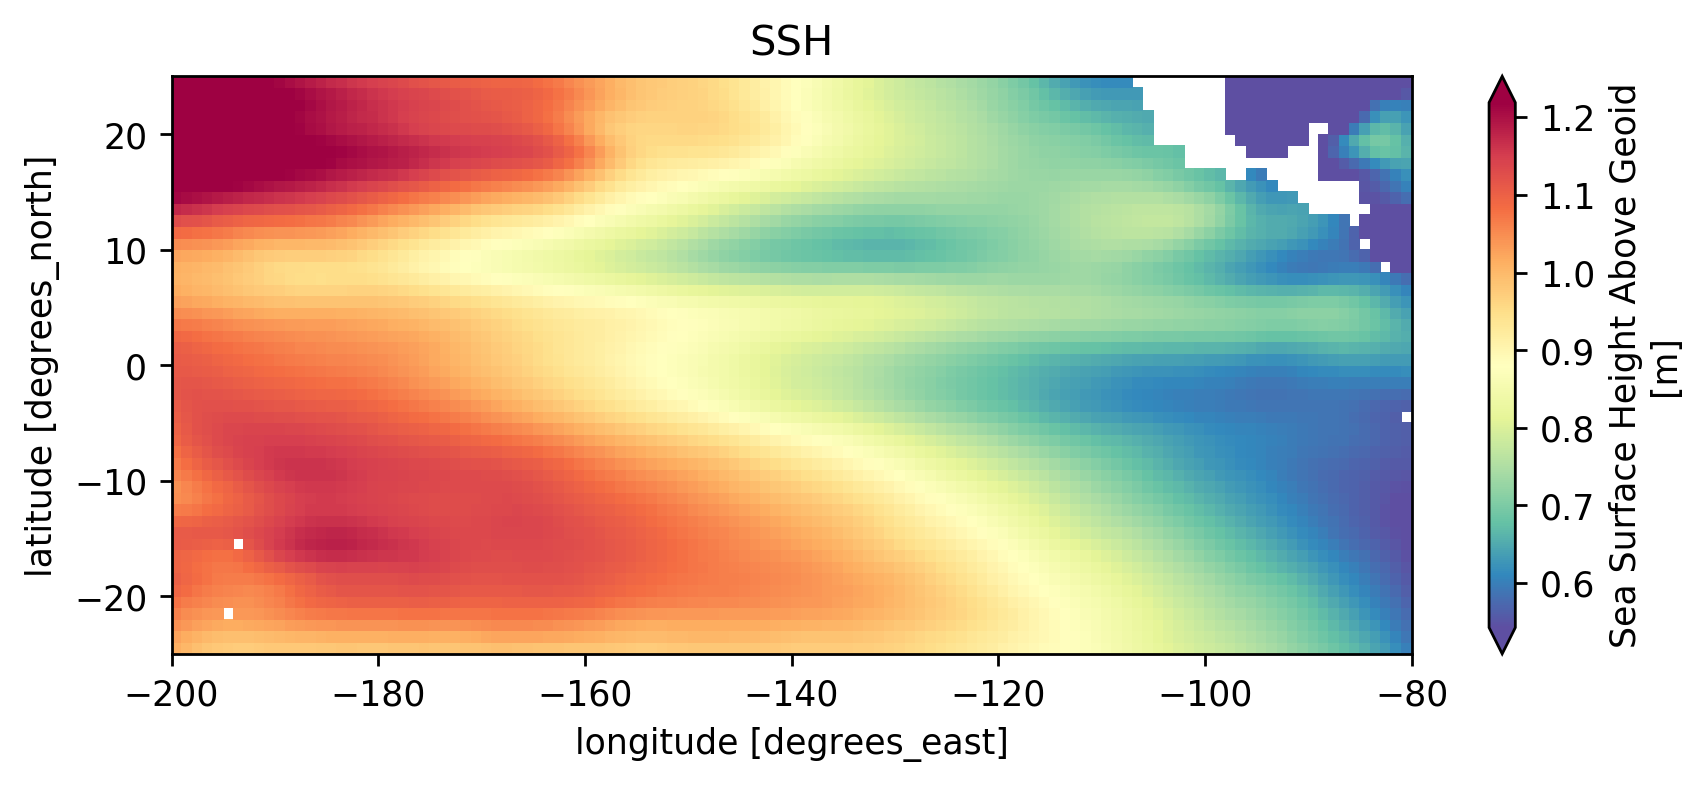

In [7]:
(ssh).plot(robust=True, cmap=mpl.cm.Spectral_r)
plt.gcf().set_size_inches((8, 3))
plt.gca().set_title('SSH')

Text(0.5, 1.0, '$∂/∂_x$ SSH')

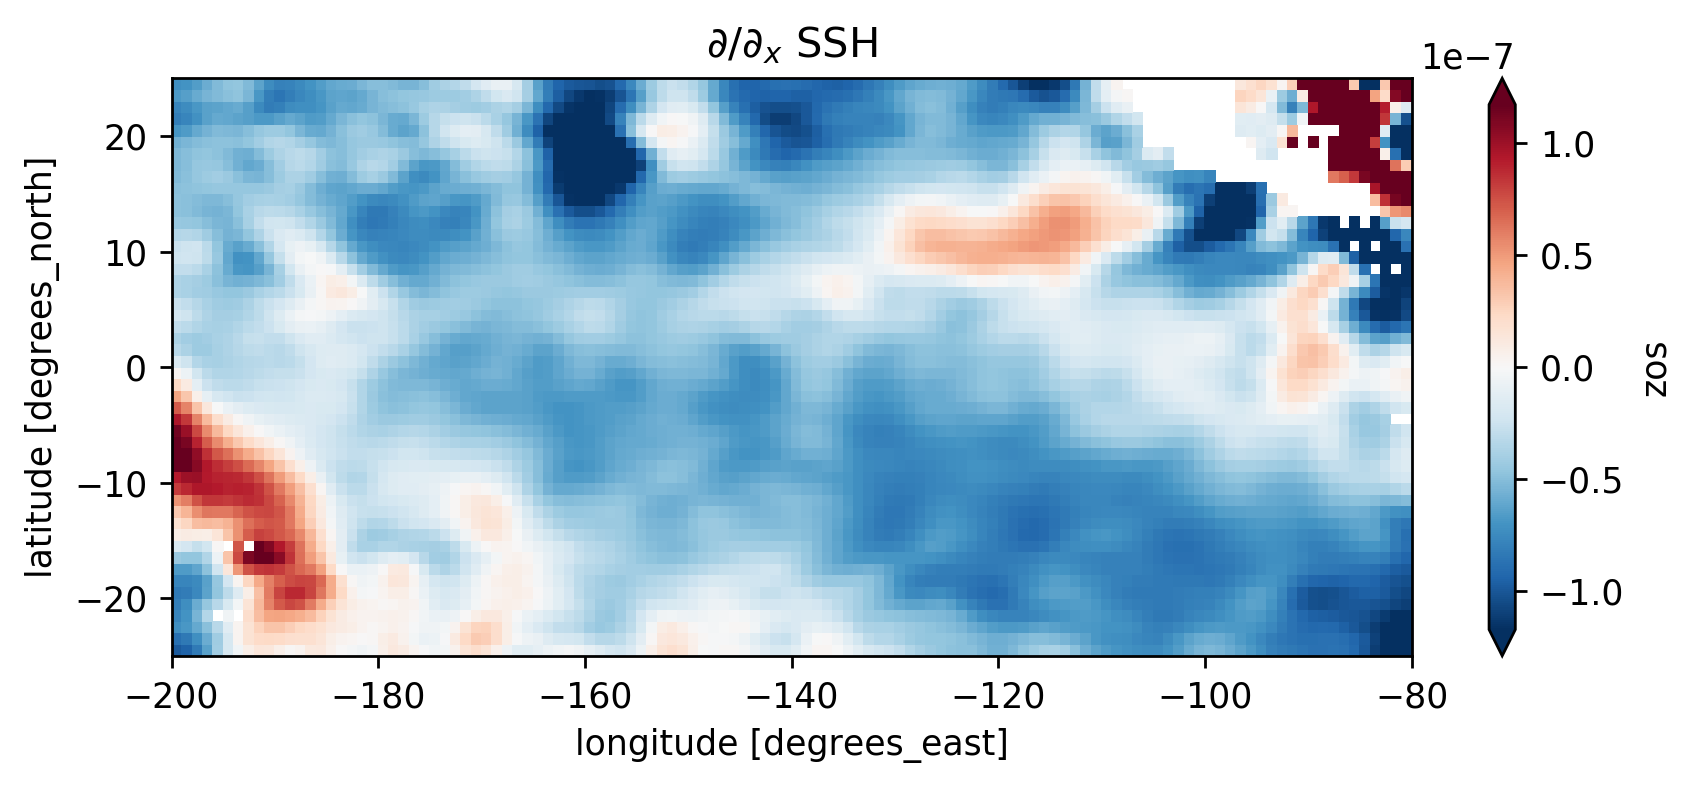

In [8]:
(ssh.differentiate('longitude')/110e3).plot(robust=True)
plt.gcf().set_size_inches((8, 3))
plt.gca().set_title('$∂/∂_x$ SSH')

## TAO wind

In [10]:
tau = (xr.open_mfdataset('../glade/obs/tao/tau[x-y]_*_dy.cdf')
      .rename({'TX_442': 'taux',
               'TY_443': 'tauy',
               'lat': 'latitude',
               'lon': 'longitude'}))
tau['longitude'] -= 360
tau = tau.where((tau.taux < 5) & (tau.tauy < 5))

tao = xr.merge([
    tao,
    tau.mean('time').sel(
        latitude=0, longitude=tao.longitude).squeeze().drop('depth').load()[['taux', 'tauy']],
    qnet.sel(latitude=0)
    .reindex(longitude=tao.longitude)
    .squeeze().drop('depth')
    .mean('time')
])
tao['tau'] = np.hypot(tao.taux, tao.tauy)
tao = tao.squeeze()
tao

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.13 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/gpfs/u/home/dcherian/python/xarray/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.1

<xarray.Dataset>
Dimensions:    (longitude: 6)
Coordinates:
    latitude   float64 0.0
  * longitude  (longitude) float64 -213.0 -204.0 -195.0 -170.0 -140.0 -110.0
Data variables:
    us         (longitude) float32 -0.06934669 0.08536129 ... 0.011650631
    ueuc       (longitude) float64 0.3355 0.4491 0.4932 0.6898 1.049 0.965
    du         (longitude) float64 -0.4049 -0.3638 -0.4965 ... -1.149 -0.9534
    eucmax     (longitude) float32 -225.0 -200.0 -195.0 -155.0 -105.0 -75.0
    bs         (longitude) float64 -9.783 -9.783 -9.785 -9.795 -9.799 -9.8
    beuc       (longitude) float64 -9.81 -9.81 -9.81 -9.81 -9.81 -9.81
    db         (longitude) float64 0.0273 0.02699 0.02499 ... 0.01052 0.009748
    h          (longitude) float32 -205.0 -180.0 -175.0 -135.0 -85.0 -55.0
    Ri         (longitude) float64 34.14 36.72 17.75 2.764 0.6773 0.5898
    taux       (longitude) float32 -0.0027862845 -0.005322009 ... -0.028835593
    tauy       (longitude) float32 -0.0014525932 0.0005883495 ...

Text(0.5, 1.0, 'Time averaged TAO wind stress')

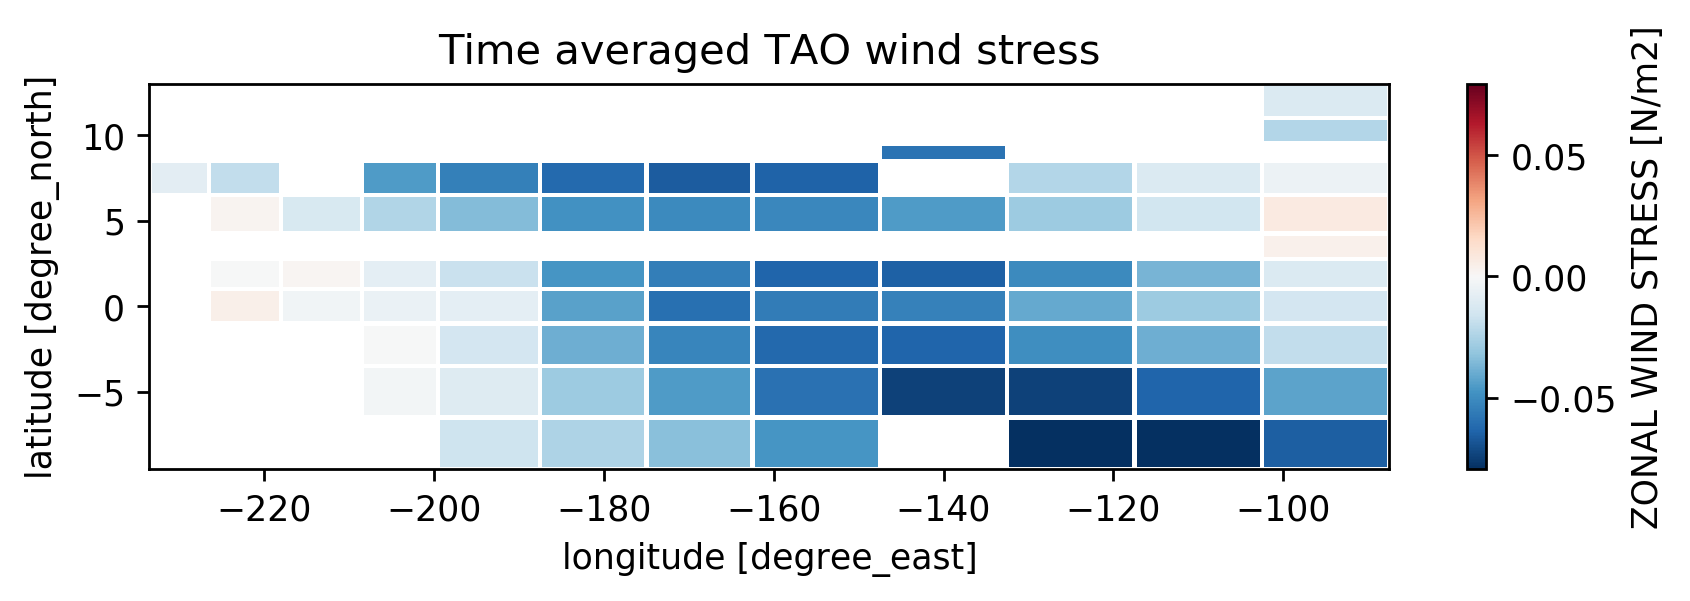

In [11]:
tau.mean('time').taux.plot(edgecolor='w')
plt.gcf().set_size_inches((8, 2))
plt.gca().set_title('Time averaged TAO wind stress')

In [3]:
cluster.scale(24)

In [6]:
# 37 seconds

%%time 
ds0 = xr.open_mfdataset("/glade/p/cesm/community/ASD-HIGH-RES-CESM1/hybrid_v5_rel04_BC5_ne120_t12_pop62/ocn/proc/tseries/monthly/*UVEL*.nc", parallel=True, concat_dim="time", combine='nested')

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.13 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/gpfs/u/home/dcherian/python/xarray/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


CPU times: user 23.5 s, sys: 5.44 s, total: 28.9 s
Wall time: 34 s


<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 504, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t_150m            (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_t                 (z_t) float32 500.0 1500.0 ... 562499.06 587499.06
  * z_w                 (z_w) float32 0.0 1000.0 2000.0 ... 549999.06 574999.06
  * z_w_bot             (z_w_bot) float32 1000.0 2000.0 ... 574999.06 599999.06
  * z_w_top             (z_w_top) float32 0.0 1000.0 ... 549999.06 574999.06
  * time                (time) object 0045-02-01 00:00:00 ... 0087-01-01 00:00:00
    ULONG               (time, nlat, nlon) float64 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    ULAT                (time, nlat, nlon) float64 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    TLONG               (time, nlat, nlon) float64 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    TLAT                (time, nlat, nlon) float64 das

In [24]:
%%time 
ds = xr.open_mfdataset("/glade/p/cesm/community/ASD-HIGH-RES-CESM1/hybrid_v5_rel04_BC5_ne120_t12_pop62/ocn/proc/tseries/monthly/*.nc", 
                       parallel=True, concat_dim='time', coords="minimal", data_vars="minimal", compat='override')

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.13 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  


CPU times: user 19 s, sys: 504 ms, total: 19.5 s
Wall time: 23 s


\begin{align}
Ri &= \frac{2 \bar{w} h Q}{\left(b_{euc}hη_x + Δb/2 h h_x + τ_w \right)²} \\
\frac{Ri}{\bar{w}} &= \frac{10^2 10^{-8}}{\left(10×10^2×10^{-8} + 10^{-2} × 10^2 × 10^{-5} + 10^{-5}\right)²} = \frac{10^{-6}}{10^{-10}} = 10^{-4}
\end{align}

*Assumptions:*
1. Linear $w$ which is 0 at EUCmax: $w = \bar{w} (1+z/h)$ This is diathermal $w$ since this form says that $w=0$ at $z=-h$ i.e. $\bar{w}$ is diathermal velocity at the top of the layer
2. Linear $u$ between EUCmax and surface

*Choices:*
1. Fill TAO qnet using linear interpolation.
2. Running mean SSH over 20 points (20°) in longitude, then calculate gradient $η_x$

Text(0.5, 1.0, 'denominator = $(-ghη_x + Δb/2 h h_x + τ/ρ_0)²$')

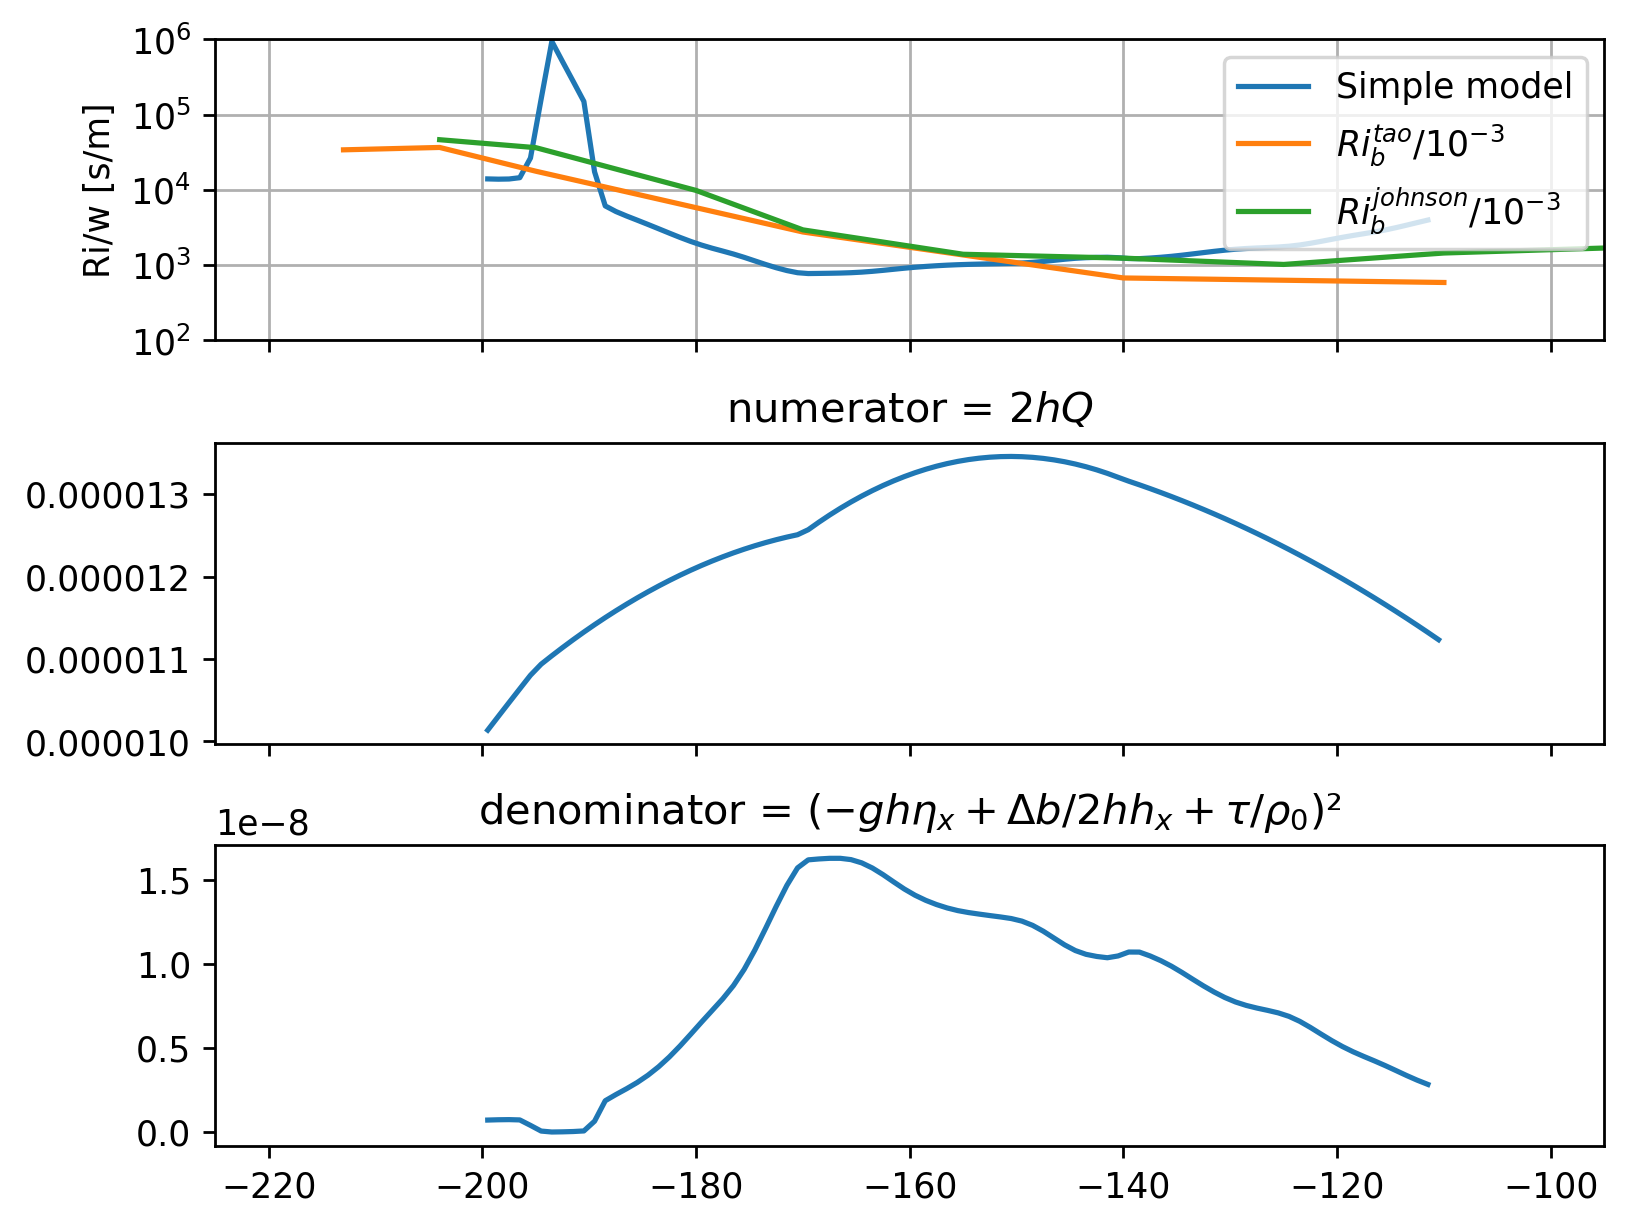

In [105]:
xr.set_options(keep_attrs=False)

# interpolate to SSH longitudes
ds = tao.interp(longitude=ssh.longitude)
# Fill qnet using linear interpolation
ds['qnet'] = (tao.qnet.dropna('longitude')
              .interp(longitude=ssh.longitude, kwargs={'fill_value': "extrapolate"}))

db = ds.db
beuc = -9.81  # b = -gρ/ρ_{euc}
Q = ds.qnet * 9.81 * 2e-4 / (1025 * 4200)  # g α Q / (ρ c_p): heat flux in W/m² → m²/s³
h = np.abs(ds.eucmax)  # derivation integrates from z=-h to z=η, so h is positive
hx = h.differentiate('longitude')/110e3
sshx = (ssh.sel(latitude=0, method='nearest')
        .rolling(longitude=20, center=True, min_periods=5)
        .mean()
        .differentiate('longitude'))/110e3

num = 2 * h *  Q
den = (beuc * h * sshx + db/2 * h * hx + ds.tau/1025)**2

Riow = num / den
Riow.attrs['long_name'] = '$Ri/w$'
Riow.attrs['units'] = 's/m'

num.attrs['units'] = 'm³/s³'
den.attrs['units'] = 'm⁴/s⁴'


f, ax = plt.subplots(3, 1, sharex=True, sharey=False, constrained_layout=True)
Riow.plot(ax=ax[0], yscale='log', ylim=[1e2, 1e6], xlim=[-225, -95], label='Simple model', _labels=False)
(10**3 * tao.Ri).plot(ax=ax[0], label='$Ri_b^{tao}/10^{-3}$', _labels=False)
(10**3 * johnson.Ri).plot(ax=ax[0], label='$Ri_b^{johnson}/10^{-3}$', _labels=False)
ax[0].legend(loc='upper right')
ax[0].set_ylabel('Ri/w [s/m]')
num.plot(ax=ax[1], _labels=False)
den.plot(ax=ax[2], _labels=False)

ax[0].set_yticks([1e2, 1e3, 1e4, 1e5, 1e6])
ax[0].grid(True)

ax[1].set_title('numerator = $2 h Q$')
ax[2].set_title('denominator = $(-ghη_x + Δb/2 h h_x + τ/ρ_0)²$')

In [109]:
cluster.scale(0)

## Numerator terms

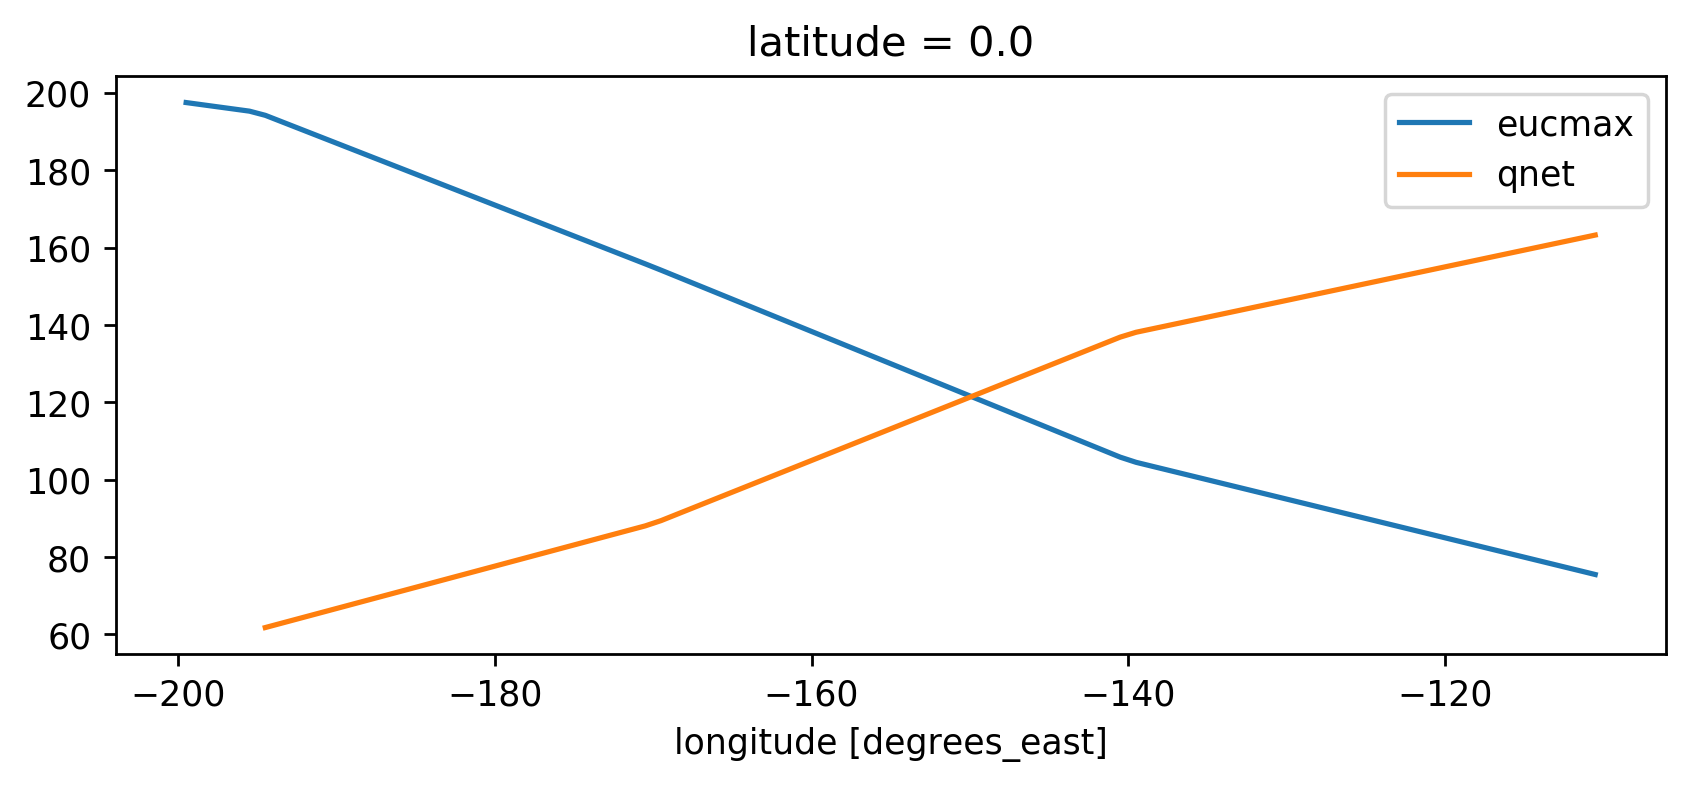

In [87]:
h.plot(label='eucmax')
ds.qnet.plot(label='qnet')
plt.gca().legend()
plt.gca().set_ylabel('')
plt.gcf().set_size_inches((8, 3))

## Denominator terms

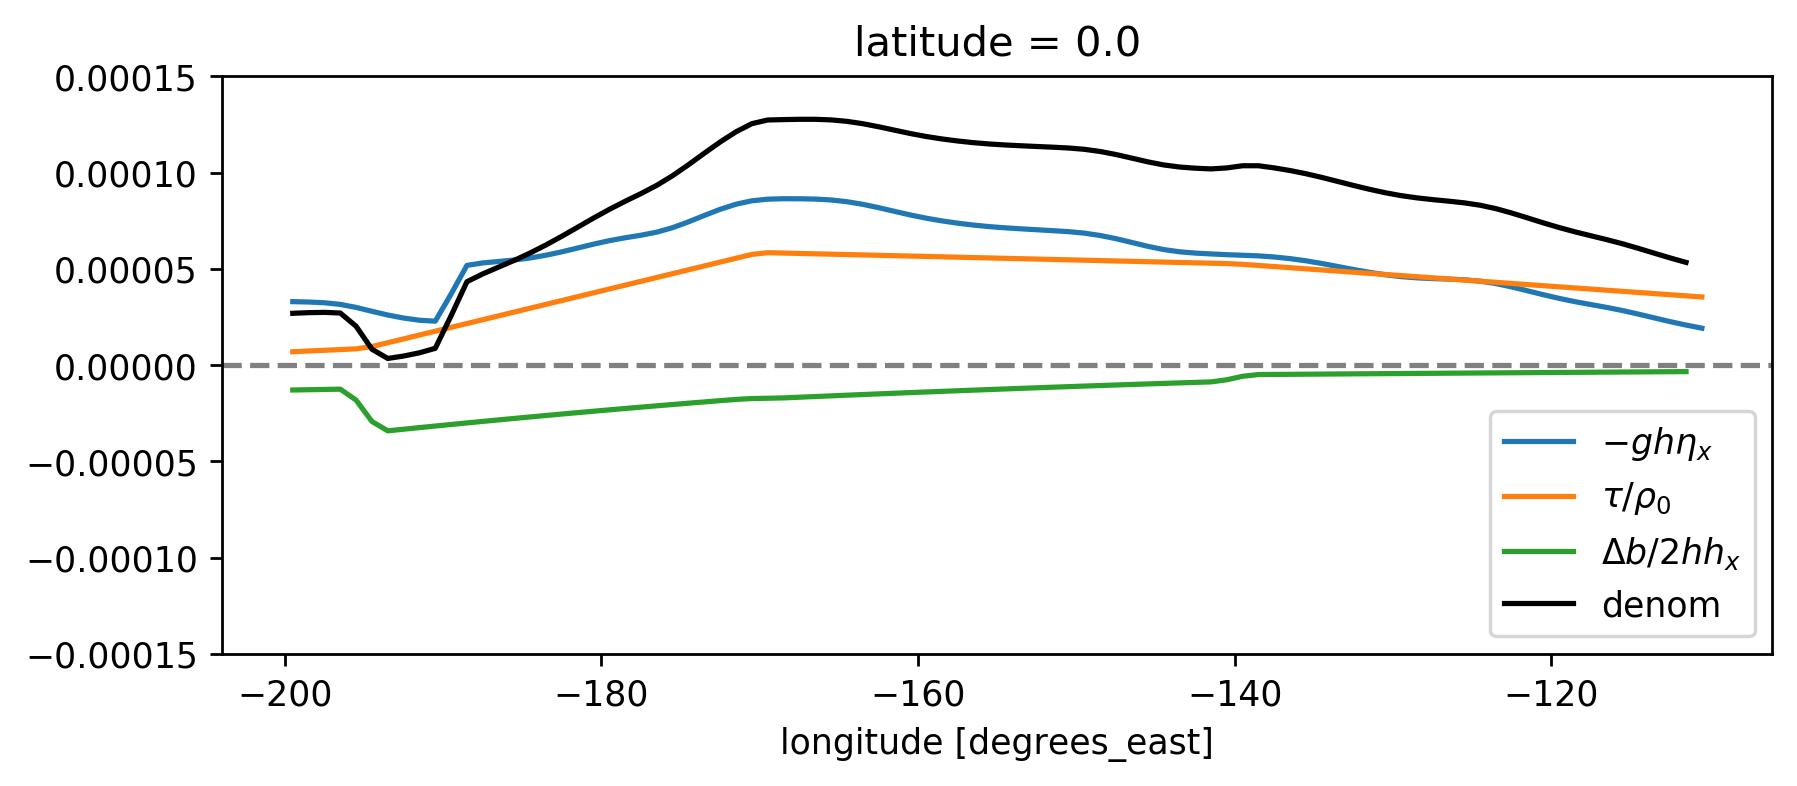

In [73]:
# den = (beuc * h * sshx + db/2 * h * hx + ds.tau/1025)**2

(beuc * h * sshx).plot(label='$-gh η_x$')
(ds.tau/1025).plot(label='$τ/ρ_0$')
(ds.db/2 * h * hx).plot(label='$Δb/2 hh_x$', ylim=[-1.5e-4, 1.5e-4])
(beuc * h * sshx + db/2 * h * hx + ds.tau/1025).plot(label='denom', color='k')
plt.gca().legend()
dcpy.plots.liney(0)
plt.gcf().set_size_inches((8, 3))

## Medians as approx.

In [26]:
print(f"η_x = {sshx.median().values:.1e}")
print(f"h_x = {hx.median().values:.1e}")
print(f"Δb/2 = {ds.db.median().values/2:.1e}")

η_x = -4.3e-08
h_x = -1.5e-05
Δb/2 = 6.4e-03
